In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from motion_planning_utils_scip import *
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly
import pyclipper
from pyscipopt import *
import json
import scenarios

# Project 4 - Motion Planning

### Introduction to Trajectory Optimization
As you know, the Big Bad Guy in Black is desperate to find the intruder lurking somewhere aboard the ~~moon~~ space station. He has tasked his droids to travel to each work station and make sure that the intruder isn't trying to deactivate tractor beams or convert young minds to his strange space religion.

In this task, we will provide trajectories for each droid, in between workstations. We are
given a qualitative state plan with sequences of workstations each robot must visit, as well as a more
detailed description of the layout of the ~~moon~~ space station, including obstacles. We will
output a set of waypoints and times of arrival at each waypoint.

## Robot Dynamics

In this part, we will incorporate robot dynamics using a discrete time model. The initial location, goal locations, the geometry of space station and obstacles, and vehicle speed limits are the inputs. We ignore acceleration constraints, and will solve an optimization problem to minimize distance. We will simplify the problem by treating the robot as a point mass as well. 

Under these assumptions, a generalized dynamic equation can be written in the form:

$$\begin{array}{c}
& s_{t+1} = A_ds_t + B_du_t \\\
\end{array}$$

where:
- $s_t$ is state (postion and velocity) of the robot at time step $t$
- $A_d$ describes the dynamics relationship between position and velocity
- $B_d$ describes the dynamics relationship between control input and velocity
- $u_t$ is the control input at time step $t$
- $\Delta t$ is the time step size within total time $T$

In our simplified robot dynamics system, we will ignore control inputs and model dynamics as a function of position and time only. The maximum velocity will be formulated as a constraint on position variables at consecutive time steps. We can therefore system dynamics to be of the form:

$$\begin{array}{c}
& s_{t+1} = A_ds_t \\\
\end{array}$$

We can translate this equation into the matrix form:

$$  \begin{pmatrix}x_{t+1}\\y_{t+1}\end{pmatrix} = \begin{pmatrix}1&0& \bigtriangleup t &0\\0&1&0&\bigtriangleup t\end{pmatrix}  \begin{pmatrix}x_{t}\\y_{t}\\\dot{x}_{t}\\\dot{y}_{t}\end{pmatrix}$$


## Modeling the problem using a mathematical programming formulation

### Choosing Decision Variables
$$
\begin{array}{c}
x_t \text{ is the x-position at time step } i \text{ for } i \in [0,1,...,T]\\ 
y_t \text{ is the y-position at time step } i \text{ for } i \in [0,1,...,T]\\ 
\end{array}
$$


### Designing an Objective Function
Since the goal is to minimize distance traveled, our objective function will seek to minimize the cumulative distance traveled during each consecutive time step. The distance between any two time steps $t-1$ and $t$ is given by:

$$
\begin{array}{c}
\sqrt{(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2}\\  
\end{array}
$$

In order to remove the complicating square-root from our objective function, we can instead minimize the square of distance, which gives us the following objective function:

$$
\begin{array}{c}
\text{OBJ: min}_t  \sum_1^T{(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2}\\  
\end{array}
$$





### Modeling Maximum Velocity Constraint
Since our system is discretized into constant-duration time steps $\Delta t$, we can model coordinate component velocity as the change position at any time step t:

$$
\begin{array}{c}
\dot{x} = (x_t - x_{t-1})/\Delta t\\
\dot{y} = (y_t - y_{t-1})/\Delta t\\
\\
\text{and then the square of velocity becomes:}\\
\\
v^2 = [(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2] / \Delta t^2\\
\end{array}
$$

$$
\begin{array}{c}
\text{If } u \text{ is the maximum velocity permitted, then } \lVert v \rVert \le u\text{, so our constraint can be written as: } \\
\\
(x_t - x_{t-1})^2 + (y_t - y_{t-1})^2 \le v^2 \Delta t^2 \quad \forall t\\
\end{array}
$$

Note that this constraint complicates the problem from a numerical solving efficiency standpoint -- the quadratic constraint brings us into the realm of Mixed-Integer Quadratically-Constrainted Programming (MIQCP)

### Encoding obstacles as constraints

Since all the obstacles in this problem are stationary, we can easily encode convex polygonal obstacles using linear constraints. Concave shapes can be dealt with by discretizing them into multiple convex objects, or by setting a convex boundary that encompasses the entire shape.

<img src="simple_sq_obs.png" style="width:50%;"/>

In the example scenario above, the obstacle is a rectangle shaped by $[x_{min}, x_{max}]$ and $[y_{min}, y_{max}]$. The positional constraint ensuring the obstacle is avoided can be expressed by: 

$$\begin{array}{l}
& \forall t  \in [1,2,3,..., T]:\\
& x_t \leq x_{min}\\
\text{or} & x_t \geq x_{max}\\
\text{or} & y_t \leq y_{min}\\
\text{or} & y_t \geq y_{max}\\
\end{array}$$

However, to make these constraints useful in solving a linear program, we need to reformulate the constraints to get rid of the "OR" statements and convert them to "AND" statements. To do this, we introduce the notion of the binary variable $z_{j,k}$:  

$$\begin{array}{l}
&& z_{j,k} \in [0,1]\\
&\text{where} & j \in [1,2,3,...J]\\
 && k \in [1,2,3,...K_j]\\
 && J \text{ is the number of polygon obstacles}\\
 && k \text{ is the index of each side of polygon obstacle j with $K_j$ total sides}\\
\end{array}$$

The binary variable $z_{j,k}$ is known as a _slack_ variable. A _slack_ variable allows us to transform and inequality into an equality, or in this case, an "OR" statement into an "AND" statement. For example, take the following inequality:

\begin{equation}
\bf{A}x \leq b
\end{equation}

We introduce the slack variable $z \geq 0$ which allows us to transform the above inequality into the following equality:

\begin{equation}
\bf{A}x + z = b
\end{equation}

Because $z$ can compensate for the "slack" between b and $\bf{A}x$ and make it so that $\bf{A}x + z$ is always equal to $b$.

Therefore, for our simple rectangle example, to transform the "OR" statements into "AND" statements, we use $z_{i,k}$ together with an arbitrarily large positive number $M$ (referred to as "Big-M" notation").

$$\begin{array}{l}
& \forall t \in [1,2,..., T]: \\
& x_t \leq x_{min} + M z_{1,1} \\
\text{and} & -x_t \leq -x_{max} + M z_{1,2} \\
\text{and} & y_t \leq y_{min} + M z_{1,3} \\
\text{and} & -y_t \leq -y_{max} + M z_{1,4} \\
\text{and} & \Sigma_{k=1}^{4} z_{j,k} \leq 3 \\
\end{array}$$


For example, $z_{j,1}=0$ if $x_t \leq x_{min}$. If $x_t \gt x_{min}$, then $z_{j,1}=1$ and since $M$ is a large positive number, we satisfy the constraint that $x_t \leq x_{min} + M z_{j,1}$. In order to classify a position $(x_t,y_t)$ as within obstacle $j$, then $\Sigma_{k=1}^{4} z_{j,k} = 4$ which has the same meaning as all of the "OR" statements in the previous section being false.


## Generalizing constraints for a n-sided polygon
The extension of the constraint enumeration to an obstacle shaped as a n-sided polygon is fairly trivial; the number of per-obstacle constraint equations is always $n+1$ with the last constraint equation resembling:
$$\Sigma_{k=1}^{n} z_{j,k} \leq n-1$$

The challenge in extending the obstacle encoding problem to obstacles shaped as n-sided polygons is the fact that an edge of the obstacle could _not_ be orthogonal to either the environment's X or Y axes. 

To begin, each polygon will have $n$ sides. We will denote each side with a pair of coordinates that correspond to the two vertexes that define the edges of the side; therefore, side $n_k = \{(x_{j,k},y_{j,k}),(x_{j,k'},y_{j,k'})\}$ such that $k \in [1,2,..n], k \neq k'$. From here, we can define a line segment for each side of the polygon

$$y_{j,k} = A_{j,k} x_{j,k} + b_{j,k}$$

Where $A_{j,k}$ is the slope of each side $l$. We can calculate $A_{j,k}$ by

$$A_{j,k} = \frac{y_{j,k'}-y_{j,k}}{x_{j,k'}-x_{j,k}}\quad s.t.\quad x_{j,k'}-x_{j,k} \neq 0\quad and \quad y_{j,k'}-y_{j,k} \neq 0$$

and calculate $b_{j,k}$ by substituting a point along the side for the values $(x_{j,k},y_{j,k})$ and solving for $b_{j,k}$. If $x_{j,k'}-x_{j,k} = 0$ or $y_{j,k'}-y_{j,k} = 0$, the side is parallel to the y-axis and x-axis, respectively. In these cases, the constraint equation for the side follows from the previous section. All sides that are not orthogonal to an axis can be represented by the following constraint equation:

$$y_{t} \leq A_{j,k}x_t + b_{j,k} + M z_{j,k}$$

Where $z_{j,k}$ and $M$ carry forward from the previous section. Therefore, the full set of constraint equations for sides of a rectangle whose sides are not orthogonal to either the x-axis or y-axis can be described by the following:

$$\begin{array}{l}
&\forall i \in [1,2,...,N]:\\
 & y_t \leq A_{j,1}x_{t} + b_{j,1} + M z_{j,1}\\
\text{and} & -y_t \leq -A_{j,2}x_{t} - b_{j,2} + M z_{j,2}\\
\text{and} & y_t \leq A_{j,3}x_{t} + b_{j,3} + M z_{j,3}\\
\text{and} & -y_t \leq -A_{j,4}x_{t} - b_{j,4} + M z_{j,4}\\
\text{and} & ...\\
\text{and} & -y_t \leq -A_{j,N}x_{t} - b_{j,N} + M z_{j,N}\\
\text{and} & \Sigma_{k=1}^{N} z_{j,k} \leq N-1\\
\end{array}$$

### Encoding Goal Constraints
Ultimately, the robot must know whether or not it has arrived at the workstation. The constraints for the goal are almost the exact opposite as the constraints for an obstacle. Instead of the requiring the robot's position to lie outside of the polygon (in the case of an obstacle), the robot's position must lie within the polygon.

In the obstacle constraint case, we needed to introduce the slack variable $z$ and the large constant $M$ because as long as all of the slack variables for a specific obstacle were not 1, the robot's position was outside of the polygon. For the case of the goal, however, the robot must satisfy all of the polygon's constraints. Therefore, for a 4 sided polygon the constraints can be listed as the following:

$$\begin{array}{l}
& t = T\\
& x_t \geq x_{min}\\
\text{and} & -x_t \geq -x_{max}\\
\text{and} & y_t \geq y_{min}\\
\text{and} & -y_t \geq -y_{max}\\
\end{array}$$

Note that this constraint only applies to the last itme index since we are considering a fixed arrival time, so the robot must arrive at the goal in the last time index.

### Determining the Direction of the Obstacle and Goal Inequalities
When considering a problem with multiple convex obstacles, it is necessary to develop an algorithm that will consistently return the appropriate direction of the obstacle inequalities. For obstacles, the robot's position must lie either above, below, to the left, or to the right of the constraint depending on which boundary the constraint lies upon. 

If we know a point within the obstacle or within the goal, we can determine the direction of the obstacle and goal inequalities. Since the obstacles and goals are convex, if we take the average of all of the $x$ positions and $y$ positions of the vertices and form a new point with those averages, we are guaranteed to find a point within the polygon. 

$$\begin{array}{l}
x_{inside} = \Sigma_{i}^{N} \frac{V_{x}[i]}{N} \\
y_{inside} = \Sigma_{i}^{N} \frac{V_{y}[i]}{N} \\
\end{array}$$

Such that $N$ is the number of vertices and $V[i]$ corresponds to the $(x,y)$ coordinate of vertex $i$. Using the $x$ and $y$ position of the point inside the polygon we can determine the direction of the inequality for each constraint. For the case of obstacles, if $y_{inside} \leq y_t$ then we know the constraint forms an upper boundary on the polygon and that we must flip the direction of the inequality for the obstacle constraint. The opposite is true for any goal polygon.

Feel free to change the number and location of the vertices in the following example to demonstrate how the average of all the vertex points creates a point inside of a convex polygon.

In [4]:
# Note we can also use this function, which is implemented later on:
%psource find_vertex_avg

(5.5, 5.5)


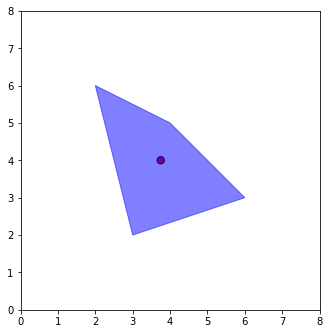

In [5]:
obstacle = [(3,2), (2,6), (4,5), (6,3)]
start = (1,1)
goal = [(6,6), (6,7), (7,7), (7, 6)]

env = Environment(None)
env.add_obstacles([Polygon(obstacle)])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)

x_inside = 0
y_inside = 0
N = len(obstacle)
for vertex in obstacle:
    x_inside = x_inside + vertex[0]*(1/N)
    y_inside = y_inside + vertex[1]*(1/N)
inside_point = (x_inside,y_inside)
    
start_point = Point(inside_point).buffer(0.1, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'red')

## Simple Robot Path Planning - Single Obstacle

We'll start by considering a simplified version of our ultimate problem, and examine constraint-based path planning throgh a single-obstacle environment to reach a single goal. In an 8x8 unit environment, we define our problem conditions as follows:

- Robot Start Point: `(1,1)`
- Goal Region: Rectangle region bounded by `[(6,6), (6,7), (7,7), (7, 6)]`
- Obstacles: Single obstacle bounded by `[(3,2), (2,6), (4,5), (6,3)]`

Our goal will be to minimize distance traveled.

Run the code in the next cell to preview the starting environment.



(5.5, 5.5)


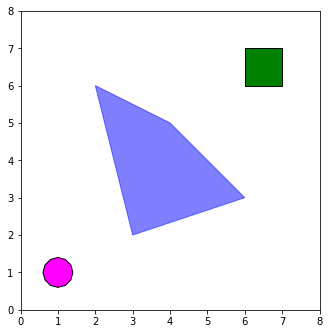

In [6]:
# Sample Problem
obstacles = [(3,2), (2,6), (4,5), (6,3)]
start = (1,1)
goal = [(6,6), (6,7), (7,7), (7, 6)]

env = Environment(None)
env.add_obstacles([Polygon(obstacles)])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.4, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, goal_region,'green')

In order to simplify the problem, we would like to treat our robot as a point object. To do this, we add a buffer, equal to the robot's radius, to every obstacle in the environment. This allows us to consider the robot as a point, rather than a moving area, and still take into account the robot's size to avoid collision with obstacles. 

To make this easy, we'll use the `pyclipper` package to create the buffer. The example code below performs this task for our example environment and obstacle, using functions defined in the `motion_planning_utils` file:

(5.5, 5.5)
Buffered Obstacle Vertices: 
 [[[6.3702459167689085, 2.9125967952422798], [4.118471829220653, 5.164370882790536], [1.7005063081160188, 6.373353643342853], [2.8583532432094216, 1.7419659039005637]]]


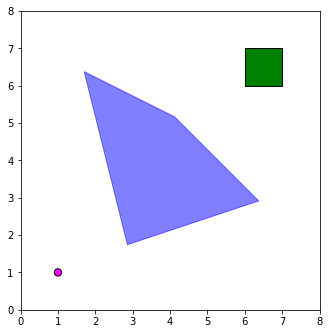

In [7]:
# Redefine obstacles with radius of droid; treat droid as a point robot
buff_obs = grow_obstacles(obstacles)
plot_env([Polygon(buff_obs[0])], start, goal, bounds)
# plot_env([Polygon(obstacles)], start, goal, bounds)
print('Buffered Obstacle Vertices: \n', buff_obs)

## Constraint Encoding Using PySCIPOpt Interface and SCIP Solver

After constructing the path planning problem as a MIQCP problem, we must encode the variables, objective function, and constraints and feed this into a solver. [PySCIPOpt](https://github.com/SCIP-Interfaces/PySCIPOpt) is a commonly-used python interface for the open-source [SCIP Solver](https://scip.zib.de/). 

The general outline is: 
 - Specify variables
 - Specify contraints over these variables
 - Construct a model with the constraints
 - Construct the solver using that model
 - Call `solve()` and extract results from variables using `get_value()`
 
As the variables and constraints are already defined above, the following section provides and example encoding of our trivial problem with a single obstacle.

**Note: Currently using Gurobi Solver instead of SCIP**

Run the cell below to view the source code to see how the optimization problem for path planning can be generated programatically, given a list of obstacles and the other problem definitions outlined above.

A note on our implementation:
- We use a `buffer` value to shift each constraint line so that the path cannot be on the obstacle edge. This is necessary because of the inability to use strict inequality constraints in the LP solver. The `buffer` can also be used to account for the width of the robot, to allow us to treat a real object as a point object. 

In [8]:
%psource create_model

### Examples
Run the code below to test an example environment. Feel free to try some of the different obstacle variations by loading various environments in the `scenarios.py` file

In [94]:
### Load appropriate dictionary from scenarios.py

locals().update(scenarios.one_obstacle)
# locals().update(scenarios.two_obstacle)
# locals().update(scenarios.quad_boxes)
# locals().update(scenarios.five_obstacle)

In [95]:
# Set problem parameters
N = 10
timestep = 1
V_max = 1
buffer = 1e-4

# Build model & optimize
m,x,y,d,bounds = create_model(start, goal, obs_list, N, timestep, V_max, buffer)
m.writeProblem(filename='m_scip_oneobs.cip')
m.optimize()


wrote problem to file b'm_scip_oneobs.cip'


In [96]:
m.getBestSol()

{'t_z(0,0,3)': -0.0, 't_z(0,0,4)': -0.0, 't_z(0,0,5)': 1.0, 't_z(0,0,6)': -0.0, 't_z(0,0,7)': -0.0, 't_z(0,0,8)': -0.0, 't_z(0,1,3)': -0.0, 't_z(0,1,4)': 1.0, 't_z(0,1,5)': -0.0, 't_z(0,1,6)': -0.0, 't_z(0,1,7)': -0.0, 't_z(0,1,8)': -0.0, 't_z(0,1,9)': -0.0, 't_z(0,2,3)': 1.0, 't_z(0,2,4)': 1.0, 't_z(0,2,5)': -0.0, 't_z(0,2,6)': -0.0, 't_z(0,2,7)': -0.0, 't_z(0,2,8)': -0.0, 't_z(0,2,9)': -0.0, 't_z(0,3,3)': -0.0, 't_z(0,3,4)': -0.0, 't_z(0,3,5)': 1.0, 't_z(0,3,6)': 1.0, 't_z(0,3,7)': 1.0, 't_z(0,3,8)': -0.0, 't_z(0,3,9)': -0.0, 't_y(2)': -0.71, 't_d(2)': 0.0, 't_x(3)': -0.6900000000000001, 't_y(3)': -0.71, 't_d(3)': 0.0, 't_x(4)': -0.6900000000000001, 't_y(4)': -0.71, 't_d(4)': 0.0, 't_x(5)': -0.6900000000000001, 't_y(5)': 3.205099999902207, 't_d(5)': 0.0, 't_x(6)': -0.6900000000000001, 't_y(6)': 5.429704087511951, 't_d(6)': 0.0, 't_x(7)': -0.6900000000000001, 't_y(7)': -0.71, 't_d(7)': 0.0, 't_x(8)': -0.6900000000000001, 't_y(8)': -0.71, 't_d(8)': 0.0, 't_x(9)': 1.7042479715246497, 't

Path Distance:  0.0
(5.345070422535212, 5.5)


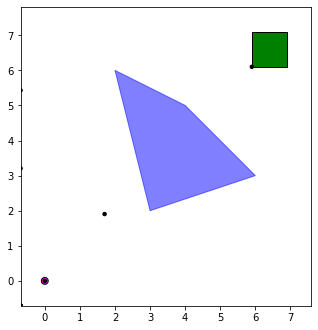

In [97]:
path_list, dist = parse_model_path(m,x,y,d)

# Plot
print("Path Distance: ", sum(dist))
ax = plot_env(obs_list, start, goal, bounds, Environment(None))
for pt in path_list:
    t_pt = Point(pt).buffer(0.05, resolution=3)
    plot_poly(ax, t_pt, 'black')    

In [92]:
path_list

[(0.0, 0.0),
 (-0.6900000000000001, -0.71),
 (-0.6900000000000001, 1.1754466926371643),
 (-0.6900000000000001, -0.71),
 (1.3693030129281505, -0.71),
 (5.3343569517767015, -0.71),
 (3.8837837126077543, 2.2944945708692366),
 (5.777805596956511, 2.332916790915994),
 (-0.6900000000000001, -0.71),
 (1.704247779055932, 3.2050999999022176),
 (5.9001, 6.100099999999999)]

In [98]:
dist

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Main Problem - Path Planning

You are currently located on our robot is currently located at start point `(0,0)`. It needs to find an optimal path to the goal region, defined as `[goal region]`, where the your communications equipment is located, in order to send out a message in time to warn your fellow comrades of the pending arrival of space intruders. There is a large obstacle of complex geometry that separates your robot from the goal region. The obstacle is actually comprised of many sub-obstacles that were compiled from multiple radar cross-sections, as shown below:

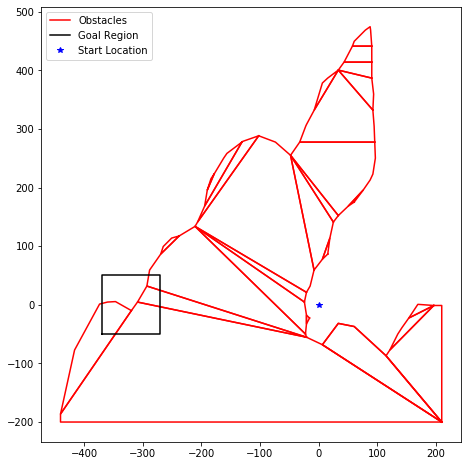

In [28]:
# Test JSON obstacle file
with open('notamoon.json') as f:
    ex_json_dict = json.load(f)
plt.figure(figsize=(14,8))

for obs in ex_json_dict['obstacles']:
    coord = np.array(obs['geometry']['coordinates'])
    plt.plot(coord[:,0],coord[:,1],'-r')

plt.gca().set_aspect('equal','box')
plt.draw()
line1,= plt.plot(coord[:,0],coord[:,1],'-r',label='Obstacles')

coord = np.array(ex_json_dict['goal']['geometry']['coordinates'])
line2,=plt.plot(coord[:,0],coord[:,1],'k-',label='Goal Region')

line3,=plt.plot(0,0,'*b',label='Start Location')
plt.legend(handles=[line1,line2,line3],loc='best')

In order to formulate the obstacles and goal region properly for our model-builder function, we must do some pre-processing to remove duplicate points in each obstacle or goal object.

In [29]:
obs_list_nm = process_json_obstacles(ex_json_dict, remove_duplicates=True)
obs_list_nmd = process_json_obstacles(ex_json_dict)

goal_region = ex_json_dict['goal']['geometry']['coordinates'][:-1]

New we are ready to build and solve the model using the same code presented above:

In [30]:
start = (0,0)
goal = goal_region
N = 16
timestep = 2
V_max = 100
buffer = 1
obs_list = obs_list_nm

m,x,y,d,bounds = create_model(start, goal, obs_list, N, timestep, V_max, buffer)

# Cutoff after 10 solutions so it doesn't run forever (optional)
# m.params.SolutionLimit = 10
m.optimize()
m.

Path Distance:  0.0


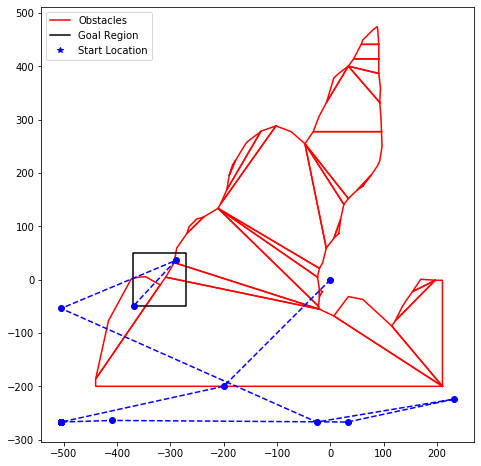

In [31]:
path_list, dist = parse_model_path(m,x,y,d)
print("Path Distance: ", sum(dist))

plt.figure(figsize=(14,8))
for obs in obs_list_nmd:
    xcoords = [obs[c][0] for c in range(len(obs))]
    ycoords = [obs[c][1] for c in range(len(obs))]
    plt.plot(xcoords,ycoords,'-r')

plt.gca().set_aspect('equal','box')
plt.draw()
# line1,= plt.plot(coord[:,0],coord[:,1],'-r',label='Obstacles')

coord = np.array(ex_json_dict['goal']['geometry']['coordinates'])
line2,=plt.plot(coord[:,0],coord[:,1],'k-',label='Goal Region')

line3,=plt.plot(0,0,'*b',label='Start Location')
plt.legend(handles=[line1,line2,line3],loc='best')

xp = [i[0] for i in path_list]
yp = [i[1] for i in path_list]
plt.plot(xp,yp, linestyle='--', marker='o', color='b')

In [32]:
path_list

[(0.0, 0.0),
 (-200.0, -200.0),
 (-505.0, -267.0),
 (-505.0, -267.0),
 (-505.0, -267.0),
 (-505.0, -267.0),
 (-505.0, -267.0),
 (-505.0, -267.0),
 (-505.0, -267.0),
 (-505.0, -267.0),
 (-409.0, -264.0),
 (32.0, -267.0),
 (232.0, -224.0),
 (-26.0, -267.0),
 (-505.0, -54.0),
 (-290.0, 36.0),
 (-369.0, -49.0)]

### **Solver Selection**

Since the problem contains quadratic constraints, we should select specific solver to solve the problem. Two possbile solvers are SCIP and Gurobi. 

Gurobi Optimizer is the the fastest and most powerful mathematical programming solver available for LP, QP and MIP (MILP, MIQP, and MIQCP) problems, although Gurobi is not open-source.

SCIP is currently one of the fastest non-commercial solvers for mixed integer programming (MIP) and mixed integer nonlinear programming (MINLP). It is also a framework for constraint integer programming and branch-cut-and-price. It allows for total control of the solution process and the access of detailed information down to the guts of the solver.

Both the two solvers are fast and easy to implement with PySCIPOpt, and syntax is nearly identical. 

## Conclusion
- Discussion of results
- Considerations for added complexity (multi-vehicle, fixed arrival time, etc)
- Sources & resources